7
[{'point_x': 1132, 'point_y': 1620, 'm0': -0.017641996557659207, 'm1': 0.6745419479267116, 'b0': 1639.9707401032701, 'b1': 856.4185149469624}, {'point_x': 1621, 'point_y': 1955, 'm0': 0.6743626743626744, 'm1': -0.06995230524642289, 'b0': 861.8581048581048, 'b1': 2068.3926868044514}, {'point_x': 2952, 'point_y': 1863, 'm0': -0.07024586051179127, 'm1': 0.267840593141798, 'b0': 2070.365780230808, 'b1': 1072.3345690454125}, {'point_x': 3917, 'point_y': 1789, 'm0': 0.17637917637917638, 'm1': -0.07028753993610223, 'b0': 1098.122766122766, 'b1': 2064.3162939297126}, {'point_x': 771, 'point_y': 1628, 'm0': -0.017641996557659207, 'm1': 1.5397350993377483, 'b0': 1641.6019793459552, 'b1': 440.86423841059604}, {'point_x': 2801, 'point_y': 1594, 'm0': -0.017444601603017446, 'm1': 0.17550274223034734, 'b0': 1642.8623290900518, 'b1': 1102.416819012797}, {'point_x': 3014, 'point_y': 1589, 'm0': -0.017641996557659207, 'm1': 0.15846456692913385, 'b0': 1642.1729776247848, 'b1': 1111.3877952755906}]
[[1

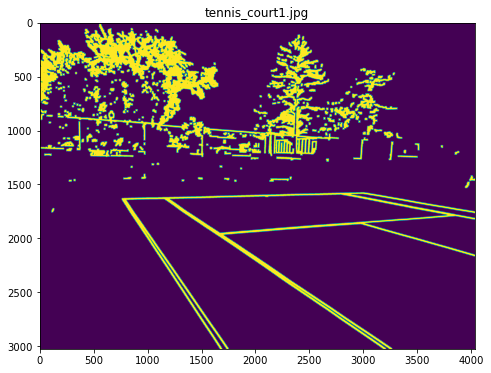

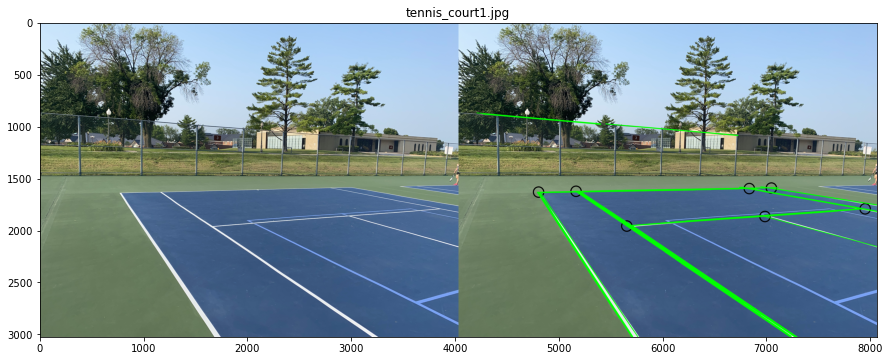

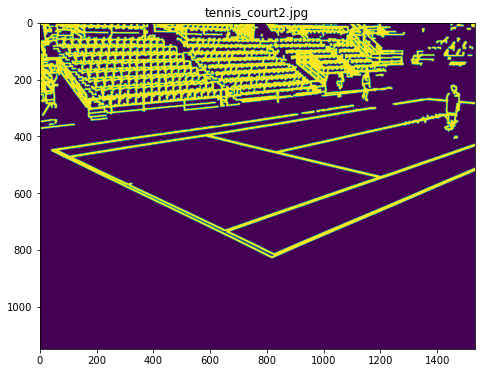

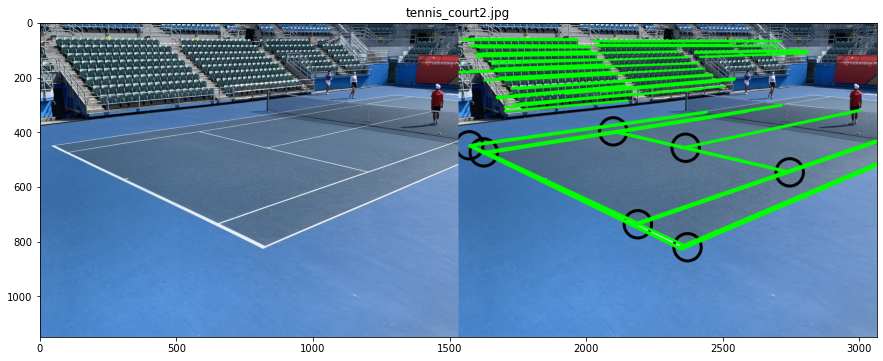

<Figure size 1080x432 with 0 Axes>

In [35]:
import os
import cv2
import numpy as np
from skimage import transform
from matplotlib import pyplot as plt

#cycle over parameter tuning until 7 points found that fall in 3-point and 4-point lines
canny_threshold0 = 761
canny_threshold1 = 324
redundant_point_difference = 56

def check_if_court_feature(point, other_point, line):
    lx0 = line[0]
    ly0 = line[1]
    lx1 = line[2]
    ly1 = line[3]
    point_x = point[0]
    point_y = point[1]
    other_point_x = other_point[0]
    other_point_y = other_point[1]
    px = lx1 - lx0
    two_point_x_diff = point_x - other_point_x
    
    if px != 0 and two_point_x_diff != 0:
        py = ly1 - ly0
        m0 = py/px
        m1 = (point_y - other_point_y)/two_point_x_diff
        angle = np.arctan((m1 - m0)/(1 + m0*m1))
        
        if abs(angle) > .1:
            norm = px*px + py*py
            u =  ((point_x - lx0) * px + (point_y - ly0) * py) / float(norm)

            if u > 1:
                u = 1
            elif u < 0:
                u = 0

            x = lx0 + u * px
            y = ly0 + u * py
            dx = x - point_x
            dy = y - point_y

            if (dx*dx + dy*dy)**.5 < 2:
                add_point = True
                
                for court_point in court_points:
                    if ((point_x - court_point["point_x"])**2 + (point_y - court_point["point_y"])**2)**.5 < redundant_point_difference:
                        add_point = False
                
                if add_point:
                    court_points.append({"point_x": point_x, "point_y": point_y, "m0": m0, "m1": m1, "b0": point_y - point_x*m0, "b1": point_y - point_x*m1})
                    cv2.circle(line_img, point, 50, 0, thickness=10)

def F(Z):
    return Z.append(1)
                    
def process_image(image):
    global line_img
    global court_points
    rgb_img = cv2.cvtColor(cv2.imread(directory+'/'+image), cv2.COLOR_BGR2RGB)
    width = rgb_img.shape[0]
    dilation_level = round(width/200)
    min_line_distance = round(width/3)
    max_line_gap = round(width/200)
    hough_threshold = round(width/2)
    line_img = rgb_img.copy()
    dilated = cv2.dilate(cv2.Canny(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY), canny_threshold0, canny_threshold1, apertureSize = 3), np.ones((dilation_level, dilation_level)))
    linesP = cv2.HoughLinesP(dilated, 1, np.pi/180, hough_threshold, None, min_line_distance, max_line_gap)
    number_of_lines = len(linesP)
    court_points = []
    
    for i in range(number_of_lines):
        s0 = linesP[i][0]
        s0end0 = (s0[0], s0[1])
        s0end1 = (s0[2], s0[3])
        cv2.line(line_img, s0end0, s0end1, (0, 255, 0), 5, cv2.LINE_AA)
        
        for j in range(i+1, number_of_lines):
            s1 = linesP[j][0]
            s1end0 = (s1[0], s1[1])
            s1end1 = (s1[2], s1[3])
            check_if_court_feature(s0end0, s0end1, s1)
            check_if_court_feature(s0end1, s0end0, s1)
            check_if_court_feature(s1end0, s1end1, s0)
            check_if_court_feature(s1end1, s1end0, s0)
            
    print(len(court_points))
    number_of_court_points = len(court_points)
    slope0_idxs = []
    slope1_idxs = []
    
    if number_of_court_points == 7:
        starting_idx = 0
        three_and_four_set_found = False
        while starting_idx < 7 and not three_and_four_set_found:
            for comparitor_idx in range(7):
                if starting_idx != comparitor_idx:
                    if abs(court_points[starting_idx]["m0"]*court_points[comparitor_idx]["point_x"] + court_points[starting_idx]["b0"] - court_points[comparitor_idx]["point_y"]) < 10:
                        slope0_idxs.append(comparitor_idx)
                        
                    if abs(court_points[starting_idx]["m1"]*court_points[comparitor_idx]["point_x"] + court_points[starting_idx]["b1"] - court_points[comparitor_idx]["point_y"]) < 10:
                        slope1_idxs.append(comparitor_idx)
            set0 = []
            set1 = []
            
            if len(slope0_idxs) == 3 or len(slope0_idxs) == 4:
                three_and_four_set_found = True
                
                for i in range(7):
                    if i in slope0_idxs:
                        set0.append(court_points[i])
                    else:
                        set1.append(court_points[i])
                            
            elif len(slope1_idxs) == 3 or len(slope1_idxs) == 4:
                three_and_four_set_found = True
                
                for i in range(7):
                    if i in slope1_idxs:
                        set0.append(court_points[i])
                    else:
                        set1.append(court_points[i])
            
            else:          
                starting_idx += 1
                
            if three_and_four_set_found:
                set0 = sorted(set0, key=lambda d: d['point_x'])
                set1 = sorted(set1, key=lambda d: d['point_x'])
                
                if len(set0) == 4:
                    slanted_set = set0+set1
                else:
                    slanted_set = set1+set0
                    
                print(slanted_set)
                dst = np.array([[sp["point_x"], sp["point_y"]] for sp in slanted_set])
#                 dst = np.array([[sp["point_y"], sp["point_x"]] for sp in slanted_set])

                src = np.array([[0, 0], [1372, 0], [9601, 0], [10973, 0],
                        [1372, 5486], [5486, 5486], [9601, 5486]])
                
#                 src = np.array([[10973, 0], [9601, 0], [1372, 0], [0, 0] ,
#                         [9601, 5486], [5486, 5486], [1372, 5486]])

#                 src = np.array([[0, 0], [1372, 0], [9601, 0], [10973, 0],
#                         [1372, -5486], [5486, -5486], [9601, -5486]])

#                 src = np.array([[10973, 0], [9601, 0], [1372, 0], [0, 0] ,
#                         [9601, -5486], [5486, -5486], [1372, -5486]])

#                 tform = transform.estimate_transform('projective', src, dst)
#                 tform = transform.estimate_transform('affine', src, dst)
                tform = transform.estimate_transform('piecewise-affine', src, dst)
#                 tform = transform.estimate_transform('polynomial', src, dst)
                print(dst)
                print(tform(src))


#                 tform = transform.estimate_transform('projective', dst, src)
#                 print(dst)
#                 print(tform.inverse(src))

                
#                 src_list = src.tolist()
                
#                 for sp in src_list:
#                     sp.append(1)
                    
#                 print(src_list)
#                 print(tform.__dir__())



#                 new_src = np.array(src_list)
#                 new_new_src = new_src[0] @ tform
#                 print(new_new_src)
                
                
                
                
                    
                    
                    
    plt.title(image)
    plt.imshow(dilated)
    plt.figure()
    plt.title(image)
    plt.imshow(np.concatenate((rgb_img, line_img), axis=1))
    plt.figure()
    print(str(number_of_lines)+" lines found in "+image)
    
directory = 'tennis_court_images'
plt.rcParams["figure.figsize"] = 15, 6
    
for image in os.listdir('tennis_court_images'):
    process_image(image)
